<p style="font-size:36px;text-align:center"> <b>Spam Detection</b> </p>

##### Problem Statement
- Detecting whether a text or content is spam or not.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
import string
string.punctuation
from nltk.stem import PorterStemmer, SnowballStemmer
from wordcloud import WordCloud


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.linear_model import SGDClassifier
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

-----------------

### DATA OVERVIEW ::

In [212]:
df=pd.read_csv('spam.csv',sep=',',engine='python')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [213]:
df.v2.iloc[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [214]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [215]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True)

In [216]:
df.head(2)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [217]:
df.v2.iloc[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [21]:
df.shape

(5572, 2)

In [22]:
df=df.rename(columns={'v1':'target','v2':'text'})
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


-----

### DATA CLEANING ::

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [24]:
df.target.value_counts()

ham     4825
spam     747
Name: target, dtype: int64

In [29]:
# check for duplicates
df.duplicated().sum()

403

In [30]:
df.drop_duplicates(keep='first',inplace=True)

In [31]:
df.duplicated().sum()

0

In [32]:
# converting labels to numeric
encoder=LabelEncoder()
encoder.fit_transform(df['target'])

array([0, 0, 1, ..., 0, 0, 0])

In [34]:
df['target']=encoder.fit_transform(df['target'])
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
df.shape

(5169, 2)

-----------------

### EDA ::

In [36]:
df.target.value_counts()

0    4516
1     653
Name: target, dtype: int64

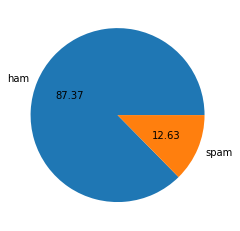

In [37]:
# its an imbalanced data set
plt.pie(df.target.value_counts(),labels=['ham','spam'],autopct='%0.2f')
plt.show()

In [50]:
df['text']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 5169, dtype: object

In [41]:
# lets have a understanding of number of words and sentences text column contains
df['num_characters']=df['text'].apply(len)

In [42]:
df['num_words']=df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [43]:
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,23
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [44]:
df['num_sentences']=df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [45]:
df.describe()

,target,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.286129,1.961308
std,0.332253,58.236293,13.226400,1.432583
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,219.000000,38.000000


- we have a max of 910 characters, 219 words and 38 sentences...


In [46]:
# ham/ not spam info
df[df['target']==0].describe()

,target,num_characters,num_words,num_sentences
count,4516.0,4516.000000,4516.000000,4516.000000
mean,0.0,70.459256,16.957484,1.815545
std,0.0,56.358207,13.394052,1.364098
min,0.0,2.000000,1.000000,1.000000
25%,0.0,34.000000,8.000000,1.000000
50%,0.0,52.000000,13.000000,1.000000
75%,0.0,90.000000,22.000000,2.000000
max,0.0,910.000000,219.000000,38.000000


In [47]:
# spam info
df[df['target']==1].describe()

,target,num_characters,num_words,num_sentences
count,653.0,653.000000,653.000000,653.000000
mean,1.0,137.891271,27.474732,2.969372
std,0.0,30.137753,6.893007,1.488910
min,1.0,13.000000,2.000000,1.000000
25%,1.0,132.000000,25.000000,2.000000
50%,1.0,149.000000,29.000000,3.000000
75%,1.0,157.000000,32.000000,4.000000
max,1.0,224.000000,44.000000,9.000000


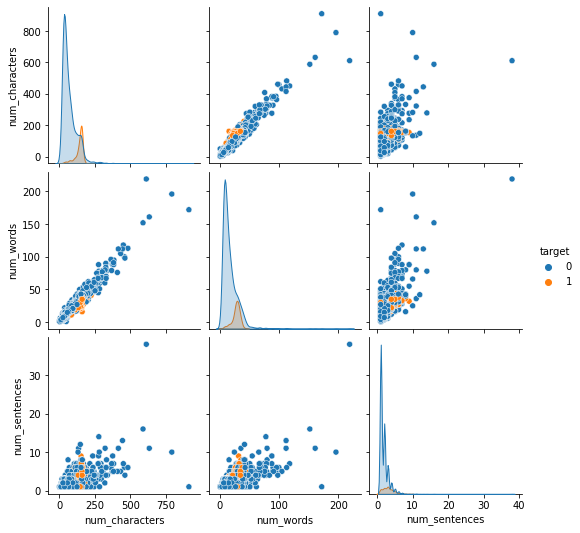

In [49]:
# have a check at the relations
sns.pairplot(df,hue='target')

- Not much helpful needs

-------------

### DATA PREPROCESSING ::

In [51]:
def transform_text(text):
    text=text.lower()
    text= nltk.word_tokenize(text)
    
    y=[]
    for i in text:
        if i.isalnum():
            y.append(i)              
    text=y[:]  
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text=y[:]  
    y.clear()
    
    ps=PorterStemmer()
    
    for i in text:
        y.append(ps.stem(i))   
        
    return " ".join(y)

In [52]:
df['text'].iloc[10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [53]:
transform_text(df['text'][10])

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [54]:
df['transformed_text']=df['text'].apply(transform_text)

In [55]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [83]:
# we can pick top 30 words from ham and spam
df[df['target']==1]['transformed_text'].tolist() [:10]

['free entri 2 wkli comp win fa cup final tkt 21st may text fa 87121 receiv entri question std txt rate c appli 08452810075over18',
 'freemsg hey darl 3 week word back like fun still tb ok xxx std chg send rcv',
 'winner valu network custom select receivea prize reward claim call claim code kl341 valid 12 hour',
 'mobil 11 month u r entitl updat latest colour mobil camera free call mobil updat co free 08002986030',
 'six chanc win cash 100 pound txt csh11 send cost 6day tsandc appli repli hl 4 info',
 'urgent 1 week free membership prize jackpot txt word claim 81010 c lccltd pobox 4403ldnw1a7rw18',
 'xxxmobilemovieclub use credit click wap link next txt messag click http',
 'england v macedonia dont miss news txt ur nation team 87077 eg england 87077 tri wale scotland poboxox36504w45wq',
 'thank subscript rington uk mobil charg pleas confirm repli ye repli charg',
 '07732584351 rodger burn msg tri call repli sm free nokia mobil free camcord pleas call 08000930705 deliveri tomorrow']

In [84]:
spam_corpus=[]
for msg in df[df['target']==1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [85]:
len(spam_corpus)

9883

In [86]:
Counter(spam_corpus).most_common(30)

[('call', 320),
 ('free', 189),
 ('2', 155),
 ('txt', 141),
 ('text', 122),
 ('u', 119),
 ('ur', 119),
 ('mobil', 114),
 ('stop', 104),
 ('repli', 103),
 ('claim', 98),
 ('prize', 82),
 ('4', 76),
 ('get', 74),
 ('new', 64),
 ('servic', 64),
 ('tone', 63),
 ('send', 60),
 ('urgent', 57),
 ('nokia', 57),
 ('contact', 56),
 ('award', 55),
 ('phone', 52),
 ('cash', 51),
 ('pleas', 50),
 ('week', 49),
 ('win', 48),
 ('c', 45),
 ('collect', 45),
 ('min', 45)]

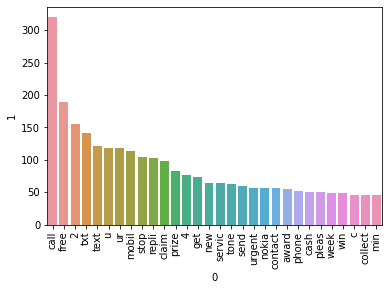

In [87]:
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0],pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

34771


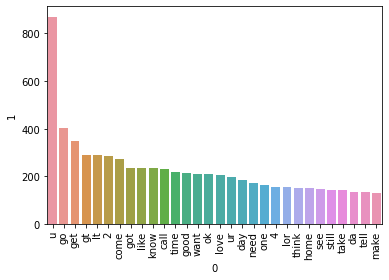

In [88]:
ham_corpus=[]
for msg in df[df['target']==0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
print(len(ham_corpus))

sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0],pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

---------------------

### Data Preparation ::

In [118]:
df1=df.drop(columns=['text','num_characters','num_words','num_sentences']).copy()

In [119]:
df1.head()

,target,transformed_text
0,0,go jurong point avail bugi n great world la e ...
1,0,ok lar joke wif u oni
2,1,free entri 2 wkli comp win fa cup final tkt 21...
3,0,u dun say earli hor u c alreadi say
4,0,nah think goe usf live around though


In [120]:
y=df1['target'].values

In [121]:
x_train,test_df,y_train,y_test=train_test_split(df1,y,test_size=0.2,random_state=42, stratify=y)
train_df,cv_df,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.2,random_state=42, stratify=y_train)

In [125]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 3308
Number of data points in test data: 1034
Number of data points in cross validation data: 827


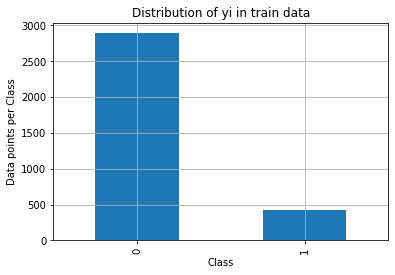

Number of data points in class 1 : 2890 ( 87.364 %)
Number of data points in class 2 : 418 ( 12.636 %)


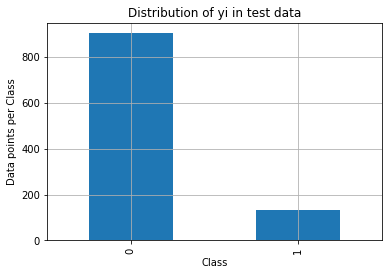

Number of data points in class 1 : 903 ( 87.331 %)
Number of data points in class 2 : 131 ( 12.669 %)


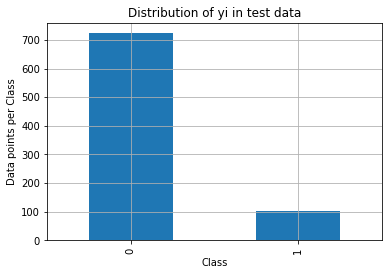

Number of data points in class 1 : 723 ( 87.424 %)
Number of data points in class 2 : 104 ( 12.576 %)


In [124]:
# Having a check of distribution of y_i's across Train, Test and Cross Validation 

train_class=train_df['target'].value_counts().sort_index()
train_class.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()
sorted_y = np.argsort(-train_class.values)
for i in sorted_y:
    print('Number of data points in class', i+1, ':',train_class.values[i], '(', np.round((train_class.values[i]/train_df.shape[0]*100), 3), '%)')


test_class=test_df['target'].value_counts().sort_index()
test_class.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()
sorted_y = np.argsort(-test_class.values)
for i in sorted_y:
    print('Number of data points in class', i+1, ':',test_class.values[i], '(', np.round((test_class.values[i]/test_df.shape[0]*100), 3), '%)')

    
cv_class=cv_df['target'].value_counts().sort_index()
cv_class.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()
sorted_y = np.argsort(-cv_class.values)
for i in sorted_y:
    print('Number of data points in class', i+1, ':',cv_class.values[i], '(', np.round((cv_class.values[i]/cv_df.shape[0]*100), 3), '%)')

    

##### - Good even distribution among train, test and CV. So we can proceed for Modeling

### MODEL BUILDING ::

- Using Naive bayes which is a baseline model for text classification

In [194]:
# final splitting
tf=TfidfVectorizer(max_features=3000)

y=df1['target'].values
x=tf.fit_transform(df1['transformed_text']).tocsr()

x_train,test_df,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42, stratify=y)
train_df,cv_df,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.2,random_state=42, stratify=y_train)

In [195]:
train_df.shape

(3308, 3000)

##### Multinomial Naive bayes

for alpha = 0.0001
F1_Score  0.86
for alpha = 0.001
F1_Score  0.88
for alpha = 0.01
F1_Score  0.89
for alpha = 0.1
F1_Score  0.91
for alpha = 1
F1_Score  0.78
for alpha = 10
F1_Score  0.0


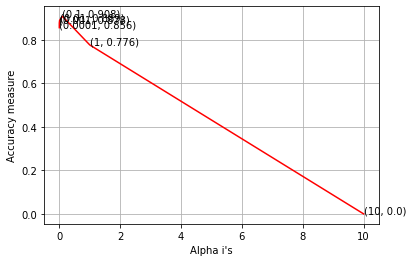

In [196]:
alpha = [10 ** x for x in range(-4, 2)]
score=[]
for i in alpha:
    print("for alpha =", i)
    clf=MultinomialNB(alpha=i)
    clf.fit(train_df,y_train)
    pred_y=clf.predict(cv_df)
    score.append(f1_score(y_cv,pred_y))
    print("F1_Score ",round(f1_score(y_cv,pred_y),2))
    
plt.plot(alpha, score,c='r')
for i in range(len(alpha)):
    plt.annotate((alpha[i],np.round(score[i],3)), (alpha[i],score[i]))
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.grid()
plt.show()

In [197]:
# applying the optimization

best_alpha = np.argmax(score)
clf=MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_df,y_train)  

pred_y=clf.predict(test_df)   # unseen data

print("F1_score ", round(f1_score(y_test,pred_y),2)*100,'%')
print("precision ",round(precision_score(y_test,pred_y),2)*100,'%')

F1_score  91.0 %
precision  95.0 %


- Having check at predictions

In [198]:
test_index = 1

predicted_cls = clf.predict(test_df[test_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(clf.predict_proba(test_df[test_index]),4))
print("Actual Class :", y_test[test_index])

Predicted Class : 0
Predicted Class Probabilities: [[0.9918 0.0082]]
Actual Class : 0


In [199]:
test_index = 1031

predicted_cls = clf.predict(test_df[test_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(clf.predict_proba(test_df[test_index]),4))
print("Actual Class :", y_test[test_index])

Predicted Class : 1
Predicted Class Probabilities: [[0. 1.]]
Actual Class : 1


##### Bernouli Naive Bayes ::

for alpha = 0.0001
F1_Score  0.89
for alpha = 0.001
F1_Score  0.9
for alpha = 0.01
F1_Score  0.92
for alpha = 0.1
F1_Score  0.94
for alpha = 1
F1_Score  0.87
for alpha = 10
F1_Score  0.0


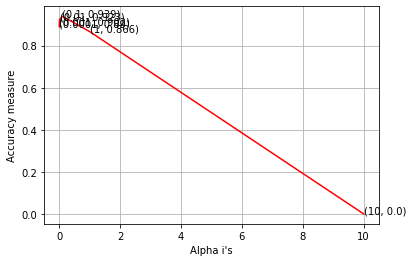

In [200]:
alpha = [10 ** x for x in range(-4, 2)]
score=[]
for i in alpha:
    print("for alpha =", i)
    clf=BernoulliNB(alpha=i)
    clf.fit(train_df,y_train)
    pred_y=clf.predict(cv_df)
    score.append(f1_score(y_cv,pred_y))
    print("F1_Score ",round(f1_score(y_cv,pred_y),2))
    
plt.plot(alpha, score,c='r')
for i in range(len(alpha)):
    plt.annotate((alpha[i],np.round(score[i],3)), (alpha[i],score[i]))
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.grid()
plt.show()

In [201]:
# applying the optimization

best_alpha = np.argmax(score)
clf=BernoulliNB(alpha=alpha[best_alpha])
clf.fit(train_df,y_train)  

pred_y=clf.predict(test_df)   # unseen data

print("F1_score ", round(f1_score(y_test,pred_y),2)*100,'%')
print("precision ",round(precision_score(y_test,pred_y),2)*100,'%')

F1_score  93.0 %
precision  98.0 %


- Bernoulli performing better than multinomial


##### Logistic Regression

for alpha = 1e-06
f1 score : 0.8795811518324608
for alpha = 1e-05
f1 score : 0.875
for alpha = 0.0001
f1 score : 0.7745664739884394
for alpha = 0.001
f1 score : 0.37209302325581395
for alpha = 0.01
f1 score : 0.0
for alpha = 0.1
f1 score : 0.0
for alpha = 1
f1 score : 0.0
for alpha = 10
f1 score : 0.0
for alpha = 100
f1 score : 0.0


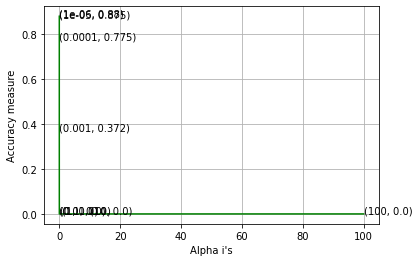

In [208]:
alpha = [10 ** x for x in range(-6, 3)]
scores = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier( alpha=i, penalty='l2', loss='log', random_state=42)   
    clf.fit(train_df,y_train)
    pred_y= clf.predict(cv_df)
    scores.append(f1_score(y_cv, pred_y))
    print("f1 score :",f1_score(y_cv, pred_y))
    

plt.plot(alpha, scores,c='g')
for i in range(len(alpha)):
    plt.annotate((alpha[i],np.round(scores[i],3)), (alpha[i],scores[i]))
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.grid()
plt.show()

In [211]:
best_alpha = np.argmax(score)
clf = SGDClassifier( alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_df,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df,y_train)
pred_y=sig_clf.predict(test_df)   # unseen data

print("F1_score ", round(f1_score(y_test,pred_y),2)*100,'%')


F1_score  84.0 %


### Conclusion :
- using Bernoulli NB as a base model.
- can alter max features and have a try with CountVectorizer to improve accuracy